In [31]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [32]:
#https://drive.google.com/file/d/1CjJyTJbyIs3rvtQh1cG0RyoKX_1inXb2/view?usp=drive_link
#https://drive.google.com/file/d/1HObEZNhDxOCCFcVnRQzW9y3w4nd_yiDx/view?usp=drive_link
#https://drive.google.com/file/d/156TEVK1L99FXA7FFfMWle-Y4nvxhfOot/view?usp=drive_link
your_file_all = drive.CreateFile({'id':'1CjJyTJbyIs3rvtQh1cG0RyoKX_1inXb2'})
your_file_ta = drive.CreateFile({'id':'1HObEZNhDxOCCFcVnRQzW9y3w4nd_yiDx'})
your_file_oc = drive.CreateFile({'id':'156TEVK1L99FXA7FFfMWle-Y4nvxhfOot'})

In [33]:
your_file_all.GetContentFile('bitcoin-all-on-chain-and-technical-indicators.csv')
your_file_ta.GetContentFile('bitcoin-all-technical-indicators.csv')
your_file_oc.GetContentFile('bitcoin-all-on-chain.csv')

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
ta_df = pd.read_csv('bitcoin-all-technical-indicators.csv')
ta_df['timestamp'] = pd.to_datetime(ta_df['timestamp'])
oc_df = pd.read_csv('bitcoin-all-on-chain.csv')
oc_df['timestamp'] = pd.to_datetime(oc_df['timestamp'])
oc_ta_df = pd.read_csv('bitcoin-all-on-chain-and-technical-indicators.csv')
oc_ta_df['timestamp'] = pd.to_datetime(oc_ta_df['timestamp'])

In [7]:
def plot_values(timestamp, *args):
    import matplotlib

    if len(args) % 2 != 0:
        raise ValueError("Every feature should have a corresponding name")

    # Use a predefined style
    plt.style.use('ggplot')

    # Set figure size
    fig, ax = plt.subplots(figsize=(12,6))

    # Create a colormap that will generate colors
    colormap = matplotlib.colormaps['tab10']

    # Plot data with customized line for each feature
    for i in range(0, len(args), 2):
        feature_name = args[i]
        feature_values = args[i+1]
        color = colormap(i // 2 / (len(args)//2))
        ax.plot(timestamp, feature_values, label=feature_name, color=color, linewidth=1)

    # Set labels with improved readability
    ax.set_xlabel('Date')
    ax.yaxis.set_label_position("right") # This line moves y label to the right
    ax.set_ylabel('Feature Values')
    ax.yaxis.tick_right() # This line moves y axis to the right
    ax.set_title('Features over Time')

    # Format the timestamps and set locator
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format as year-month-day
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # display a label at the start of every 3rd month

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add a grid
    ax.grid(True)

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

In [8]:
def data_preperation(df, lookback, future, scale, test_size=0.1):
    # Convert 'Date' column to datetime
    date_train = pd.to_datetime(df['timestamp'])
    df = df.drop(columns=['timestamp'])

    # Ensure all data is float type
    df = df.astype(float)

    # Split data into training and testing before scaling
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

    # Scale data
    df_train_scaled = scale.fit_transform(df_train)
    df_test_scaled = scale.transform(df_test)  # use the scaler fitted on the training data

    # Create the feature and target arrays
    X_train, y_train = [], []
    for i in range(lookback, len(df_train_scaled)-future+1):
        X_train.append(df_train_scaled[i-lookback:i, :])
        y_train.append(df_train_scaled[i+future-1:i+future, 0])

    X_test, y_test = [], []
    for i in range(lookback, len(df_test_scaled)-future+1):
        X_test.append(df_test_scaled[i-lookback:i, :])
        y_test.append(df_test_scaled[i+future-1:i+future, 0])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test, date_train

In [9]:
def data_preparation_returns(df, lookback, future, scale_full, scale_returns, test_size=0.1):
    # Convert 'Date' column to datetime
    date_train = pd.to_datetime(df['timestamp'])
    df = df.drop(columns=['timestamp'])

    # Ensure all data is float type
    df = df.astype(float)

    # Calculate return from price
    df['return'] = df['price'].diff()
    df = df.dropna()  # remove the first row which is NaN

    # Now drop the 'price' column as we won't use it anymore
    df = df.drop(columns=['price'])

    # Split data into training and testing before scaling
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

    # Scale full data
    df_train_scaled = pd.DataFrame(scale_full.fit_transform(df_train), columns=df_train.columns)
    df_test_scaled = pd.DataFrame(scale_full.transform(df_test), columns=df_test.columns)

    # Scale 'return' column alone
    df_train_scaled['return'] = scale_returns.fit_transform(df_train[['return']])
    df_test_scaled['return'] = scale_returns.transform(df_test[['return']])

    # Create the feature and target arrays
    X_train, y_train = [], []
    for i in range(lookback, len(df_train_scaled)-future+1):
        X_train.append(df_train_scaled.iloc[i-lookback:i, :].values)
        y_train.append(df_train_scaled.iloc[i+future-1:i+future][['return']].values)

    X_test, y_test = [], []
    for i in range(lookback, len(df_test_scaled)-future+1):
        X_test.append(df_test_scaled.iloc[i-lookback:i, :].values)
        y_test.append(df_test_scaled.iloc[i+future-1:i+future][['return']].values)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test, date_train


In [51]:
def lstm_1(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)

    model.add(Bidirectional(LSTM(units=256, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y, validation_split=0.1, epochs=50, batch_size=32)
    return model

In [48]:
def lstm_2(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)


    model.add(LSTM(20,return_sequences=True,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(15,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y,validation_split=0.1,epochs=100,batch_size=32,verbose=1)
    return model

In [12]:
def predict_price(df):
    scale = MinMaxScaler(feature_range=(0,1))
    X_train, X_test, y_train, y_test, date_train = data_preperation(df, 60, 1, scale)
    model=lstm_1(X_train, y_train)
    predictions = model.predict(X_test)
    price_scaler = MinMaxScaler(feature_range=(0,1))
    price_scaler.min_, price_scaler.scale_ = scale.min_[0], scale.scale_[0]

    # Now you can inverse_transform your predictions
    predictions = price_scaler.inverse_transform(predictions)
    y_test = y_test.reshape(-1, 1)  # reshaping
    y_test = price_scaler.inverse_transform(y_test)


    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)
    print("Mean Absolute Error (MAE):", mae)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, predictions)
    print("Mean Squared Error (MSE):", mse)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print("Root Mean Squared Error (RMSE):", rmse)

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    print("Mean Absolute Percentage Error (MAPE):", mape)

    # R-squared (R2)
    r2 = r2_score(y_test, predictions)
    print("R-squared (R2):", r2)
    plot_values(range(len(y_test)), 'test', y_test, 'predictions', predictions)

In [13]:
def predict_returns(df):
    # Create separate scalers for the full data and the 'returns' column
    scale_full = MinMaxScaler(feature_range=(0,1))
    scale_returns = MinMaxScaler(feature_range=(0,1))

    X_train, X_test, y_train, y_test, date_train = data_preparation_returns(df, 60, 1, scale_full, scale_returns)
    model = lstm_1(X_train, y_train)
    predictions = model.predict(X_test)

    # Inverse transform the predictions and y_test
    predictions = scale_returns.inverse_transform(predictions)
    y_test = y_test.reshape(-1, 1)  # reshaping
    y_test = scale_returns.inverse_transform(y_test)

    # Convert returns back to price for plotting and error metrics.
    df_train, df_test = train_test_split(ta_df, test_size=0.1, shuffle=False)

    # For the actual values
    price_test = df_test['price'][60:].values  # adjust the index according to your lookback period
    price_test = np.concatenate(([df_train['price'].iloc[-1]], price_test))
    y_test_price = np.cumsum(y_test) + price_test[:-1]

    # For the predictions
    predictions_price = np.cumsum(predictions) + price_test[:-1]

    # Now you can calculate the error metrics on the price data
    mae = mean_absolute_error(y_test_price, predictions_price)
    print("Mean Absolute Error (MAE):", mae)

    mse = mean_squared_error(y_test_price, predictions_price)
    print("Mean Squared Error (MSE):", mse)

    rmse = np.sqrt(mean_squared_error(y_test_price, predictions_price))
    print("Root Mean Squared Error (RMSE):", rmse)

    mape = np.mean(np.abs((y_test_price - predictions_price) / y_test_price)) * 100
    print("Mean Absolute Percentage Error (MAPE):", mape)

    r2 = r2_score(y_test_price, predictions_price)
    print("R-squared (R2):", r2)
    plot_values(range(len(y_test)), 'test', y_test, 'predictions', predictions)
    plot_values(range(len(y_test)), 'test price', y_test_price, 'predictions price', predictions_price)

Epoch 1/50
73/73 [==============================] - 11s 40ms/step - loss: 0.1227 - val_loss: 0.0044
Epoch 2/50
73/73 [==============================] - 2s 23ms/step - loss: 9.4381e-04 - val_loss: 0.0034
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 6.8045e-04 - val_loss: 0.0054
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 6.0304e-04 - val_loss: 0.0035
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 5.4914e-04 - val_loss: 0.0022
Epoch 6/50
73/73 [==============================] - 1s 17ms/step - loss: 4.7038e-04 - val_loss: 0.0051
Epoch 7/50
73/73 [==============================] - 1s 17ms/step - loss: 4.7038e-04 - val_loss: 0.0030
Epoch 8/50
73/73 [==============================] - 1s 17ms/step - loss: 4.1672e-04 - val_loss: 0.0017
Epoch 9/50
73/73 [==============================] - 1s 17ms/step - loss: 4.0646e-04 - val_loss: 0.0058
Epoch 10/50
73/73 [==============================] - 1s 18ms/step - loss: 4.

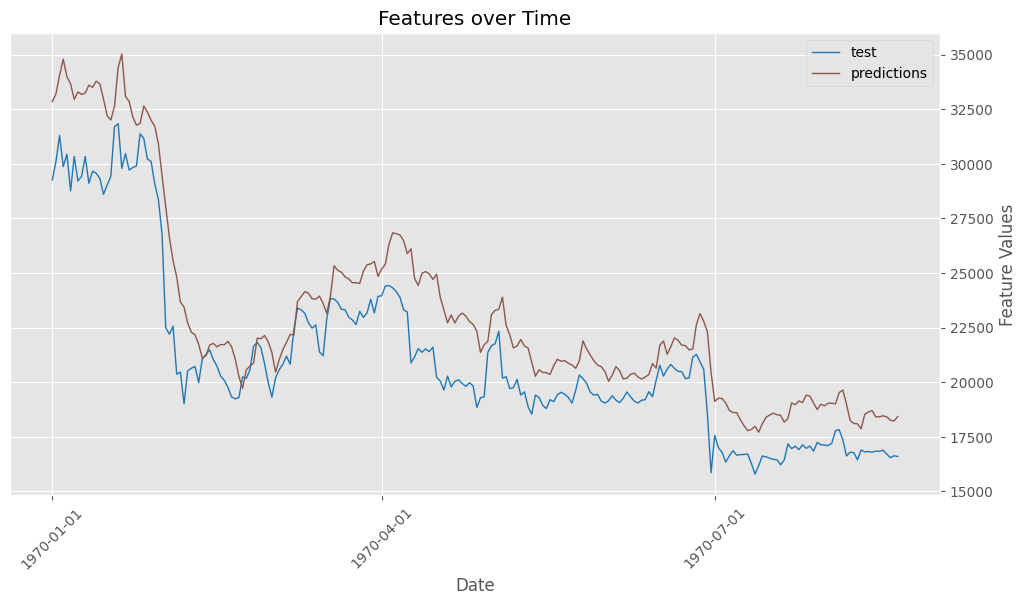

Epoch 1/50
73/73 [==============================] - 11s 36ms/step - loss: 0.1303 - val_loss: 0.0174
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 0.0157
Epoch 3/50
73/73 [==============================] - 1s 18ms/step - loss: 8.1436e-04 - val_loss: 0.0214
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 6.1916e-04 - val_loss: 0.0289
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 5.3334e-04 - val_loss: 0.0306
Epoch 6/50
73/73 [==============================] - 1s 18ms/step - loss: 5.3514e-04 - val_loss: 0.0319
Epoch 7/50
73/73 [==============================] - 2s 24ms/step - loss: 4.9489e-04 - val_loss: 0.0411
Epoch 8/50
73/73 [==============================] - 2s 22ms/step - loss: 4.5114e-04 - val_loss: 0.0343
Epoch 9/50
73/73 [==============================] - 1s 18ms/step - loss: 4.1391e-04 - val_loss: 0.0431
Epoch 10/50
73/73 [==============================] - 1s 18ms/step - loss: 3.9984

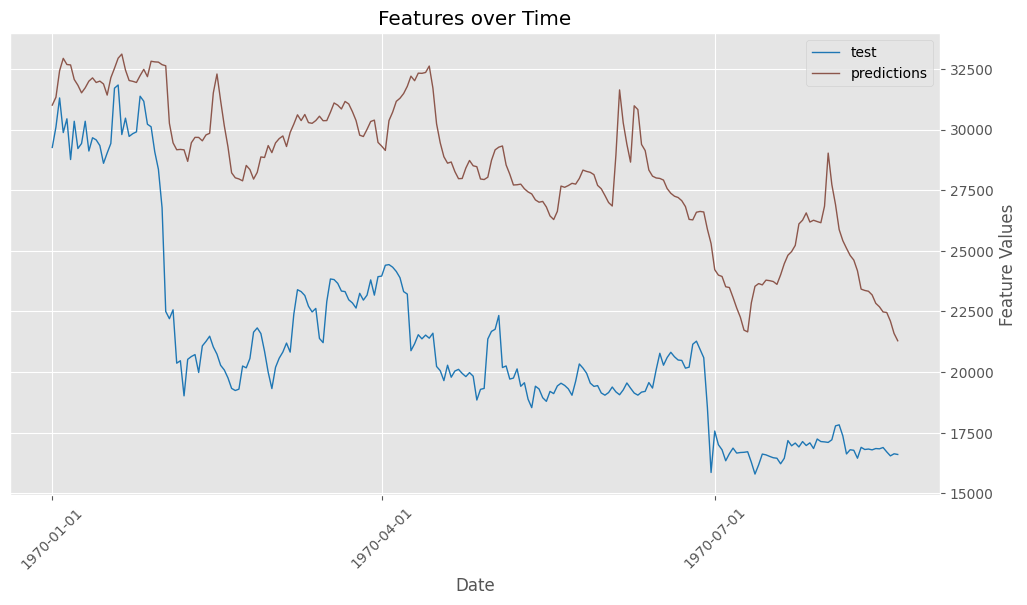

Epoch 1/50
73/73 [==============================] - 11s 37ms/step - loss: 0.1087 - val_loss: 0.0120
Epoch 2/50
73/73 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0103
Epoch 3/50
73/73 [==============================] - 2s 22ms/step - loss: 7.0601e-04 - val_loss: 0.0062
Epoch 4/50
73/73 [==============================] - 2s 27ms/step - loss: 6.1064e-04 - val_loss: 0.0074
Epoch 5/50
73/73 [==============================] - 1s 18ms/step - loss: 4.9659e-04 - val_loss: 0.0076
Epoch 6/50
73/73 [==============================] - 1s 19ms/step - loss: 4.5159e-04 - val_loss: 0.0156
Epoch 7/50
73/73 [==============================] - 1s 18ms/step - loss: 4.0471e-04 - val_loss: 0.0034
Epoch 8/50
73/73 [==============================] - 1s 18ms/step - loss: 5.8209e-04 - val_loss: 0.0047
Epoch 9/50
73/73 [==============================] - 1s 18ms/step - loss: 3.3933e-04 - val_loss: 0.0071
Epoch 10/50
73/73 [==============================] - 1s 18ms/step - loss: 3.4789

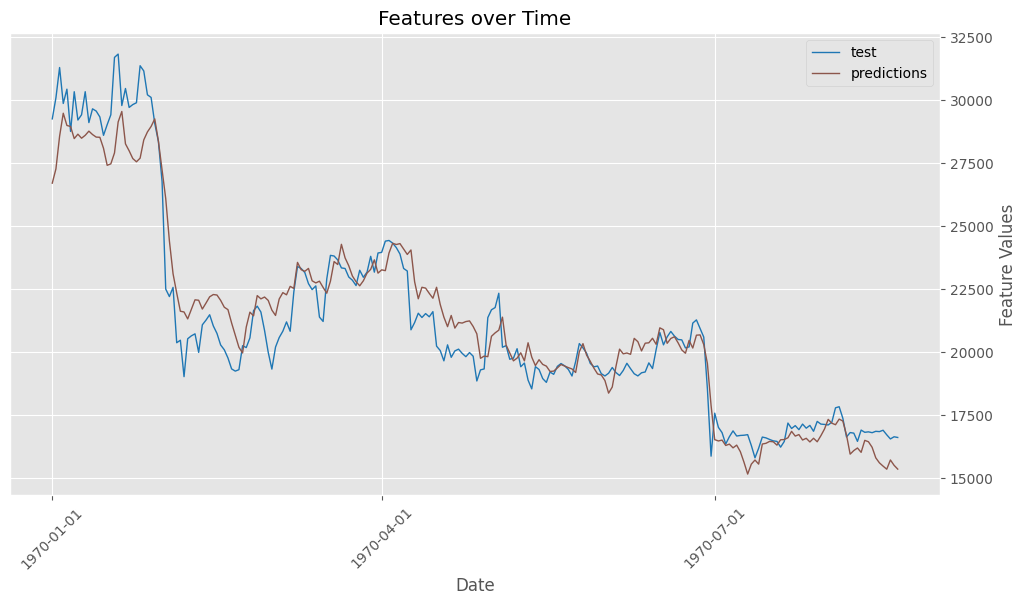

In [81]:
predict_price(ta_df)
predict_price(oc_df)
predict_price(oc_ta_df)

Epoch 1/50
73/73 [==============================] - 11s 36ms/step - loss: 0.0367 - val_loss: 0.0066
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 7.2019e-04 - val_loss: 0.0036
Epoch 3/50
73/73 [==============================] - 2s 21ms/step - loss: 5.8156e-04 - val_loss: 0.0025
Epoch 4/50
73/73 [==============================] - 2s 24ms/step - loss: 4.8074e-04 - val_loss: 0.0016
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 3.8533e-04 - val_loss: 0.0015
Epoch 6/50
73/73 [==============================] - 1s 17ms/step - loss: 3.6641e-04 - val_loss: 0.0025
Epoch 7/50
73/73 [==============================] - 1s 16ms/step - loss: 3.5746e-04 - val_loss: 0.0016
Epoch 8/50
73/73 [==============================] - 1s 17ms/step - loss: 2.8851e-04 - val_loss: 0.0016
Epoch 9/50
73/73 [==============================] - 1s 17ms/step - loss: 2.7670e-04 - val_loss: 0.0016
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 2.

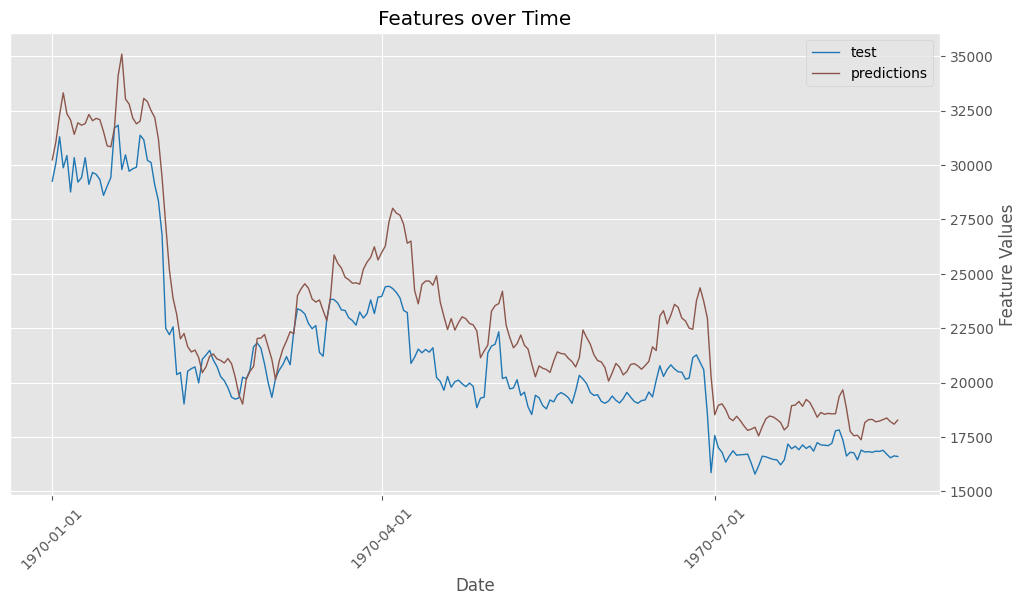

Epoch 1/50
73/73 [==============================] - 12s 39ms/step - loss: 0.1107 - val_loss: 0.0188
Epoch 2/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0149
Epoch 3/50
73/73 [==============================] - 1s 18ms/step - loss: 6.2820e-04 - val_loss: 0.0176
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 5.7458e-04 - val_loss: 0.0201
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 5.2272e-04 - val_loss: 0.0212
Epoch 6/50
73/73 [==============================] - 1s 17ms/step - loss: 5.3740e-04 - val_loss: 0.0263
Epoch 7/50
73/73 [==============================] - 1s 17ms/step - loss: 4.7205e-04 - val_loss: 0.0188
Epoch 8/50
73/73 [==============================] - 2s 21ms/step - loss: 4.2708e-04 - val_loss: 0.0199
Epoch 9/50
73/73 [==============================] - 2s 22ms/step - loss: 4.5910e-04 - val_loss: 0.0182
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 3.5941

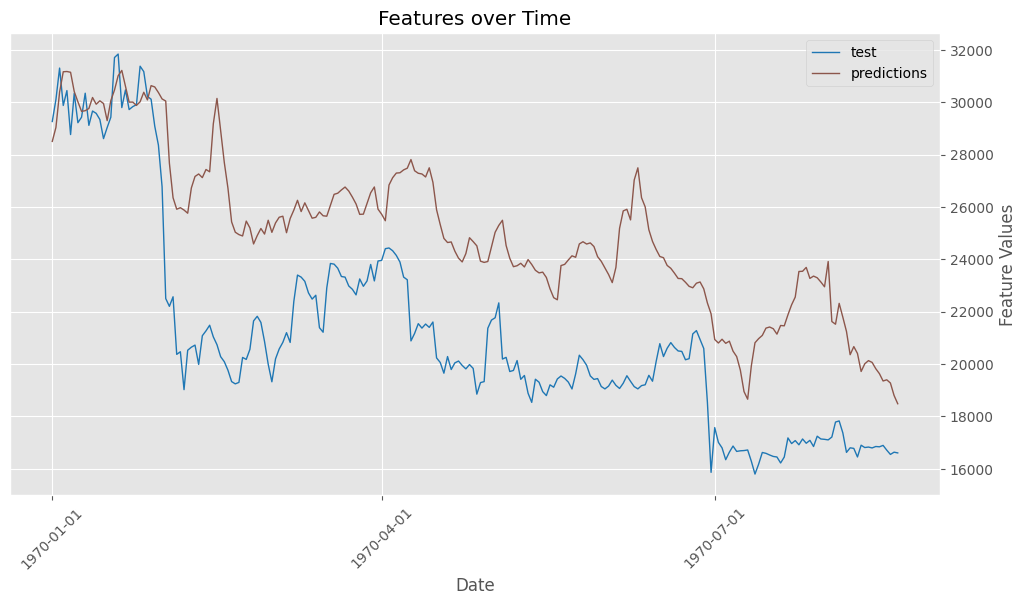

Epoch 1/50
73/73 [==============================] - 11s 37ms/step - loss: 0.2927 - val_loss: 0.0120
Epoch 2/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0082
Epoch 3/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 4/50
73/73 [==============================] - 1s 18ms/step - loss: 9.3216e-04 - val_loss: 0.0079
Epoch 5/50
73/73 [==============================] - 2s 24ms/step - loss: 8.6385e-04 - val_loss: 0.0029
Epoch 6/50
73/73 [==============================] - 1s 20ms/step - loss: 7.5378e-04 - val_loss: 0.0089
Epoch 7/50
73/73 [==============================] - 1s 18ms/step - loss: 6.8316e-04 - val_loss: 0.0056
Epoch 8/50
73/73 [==============================] - 1s 18ms/step - loss: 5.7254e-04 - val_loss: 0.0061
Epoch 9/50
73/73 [==============================] - 1s 18ms/step - loss: 4.8906e-04 - val_loss: 0.0039
Epoch 10/50
73/73 [==============================] - 1s 18ms/step - loss: 4.8962e-04

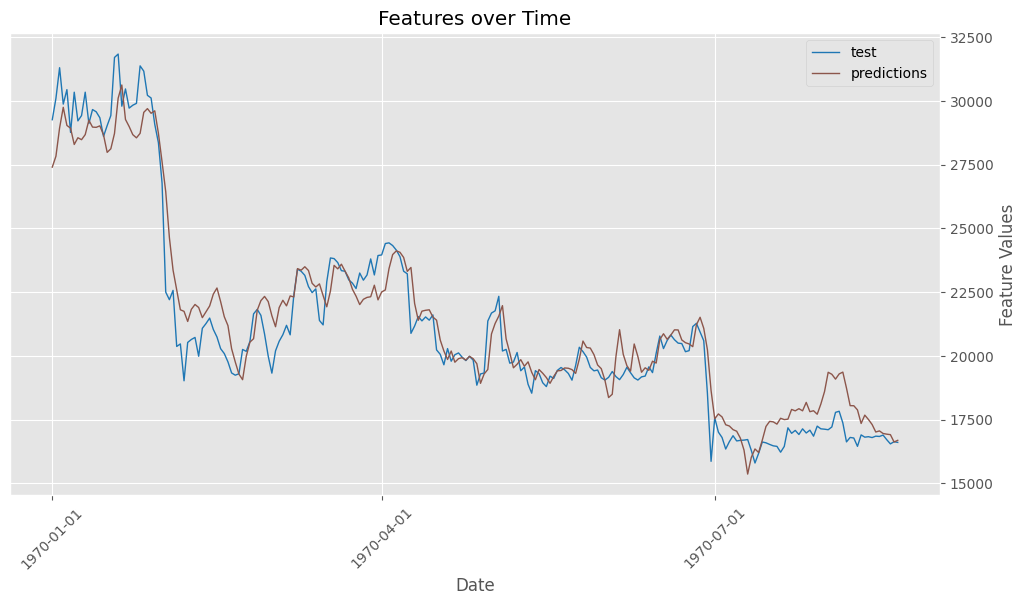

In [83]:
predict_price(ta_df)
predict_price(oc_df)
predict_price(oc_ta_df)

Epoch 1/50
73/73 [==============================] - 12s 36ms/step - loss: 0.1037 - val_loss: 0.0043
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 8.5750e-04 - val_loss: 0.0035
Epoch 3/50
73/73 [==============================] - 1s 18ms/step - loss: 6.7436e-04 - val_loss: 0.0051
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 6.0460e-04 - val_loss: 0.0018
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 4.7946e-04 - val_loss: 0.0018
Epoch 6/50
73/73 [==============================] - 1s 17ms/step - loss: 4.4576e-04 - val_loss: 0.0017
Epoch 7/50
73/73 [==============================] - 1s 17ms/step - loss: 4.6091e-04 - val_loss: 0.0015
Epoch 8/50
73/73 [==============================] - 2s 24ms/step - loss: 4.4018e-04 - val_loss: 0.0018
Epoch 9/50
73/73 [==============================] - 2s 21ms/step - loss: 4.1925e-04 - val_loss: 0.0035
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 3.

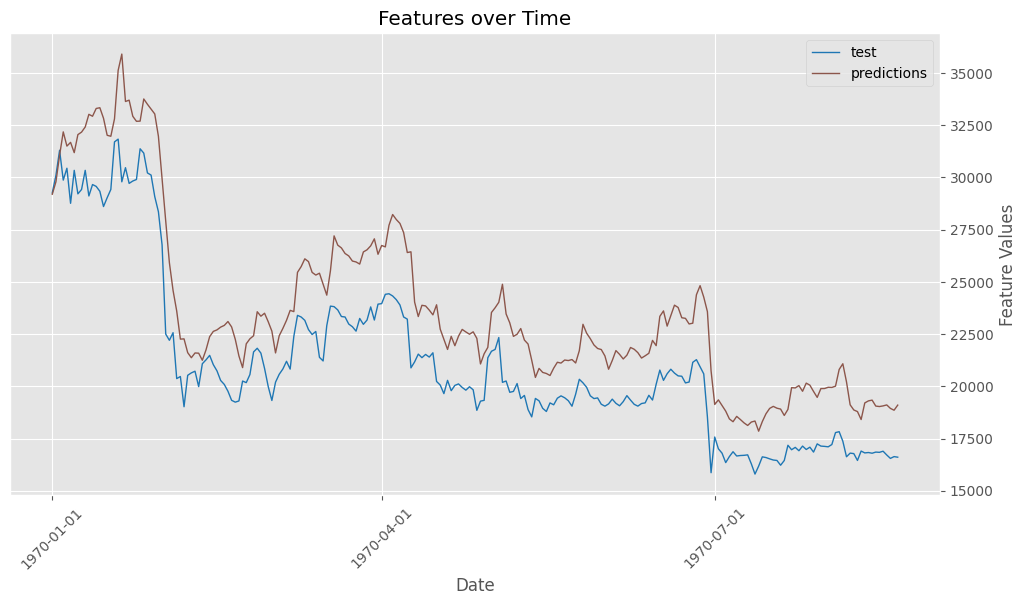

Epoch 1/50
73/73 [==============================] - 11s 36ms/step - loss: 0.1131 - val_loss: 0.0212
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 0.0494
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 6.8733e-04 - val_loss: 0.0431
Epoch 4/50
73/73 [==============================] - 1s 18ms/step - loss: 6.0327e-04 - val_loss: 0.0581
Epoch 5/50
73/73 [==============================] - 2s 24ms/step - loss: 5.3472e-04 - val_loss: 0.0430
Epoch 6/50
73/73 [==============================] - 1s 20ms/step - loss: 5.3229e-04 - val_loss: 0.0224
Epoch 7/50
73/73 [==============================] - 1s 18ms/step - loss: 5.1385e-04 - val_loss: 0.0263
Epoch 8/50
73/73 [==============================] - 1s 17ms/step - loss: 5.0189e-04 - val_loss: 0.0365
Epoch 9/50
73/73 [==============================] - 1s 18ms/step - loss: 4.0910e-04 - val_loss: 0.0407
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 3.8382

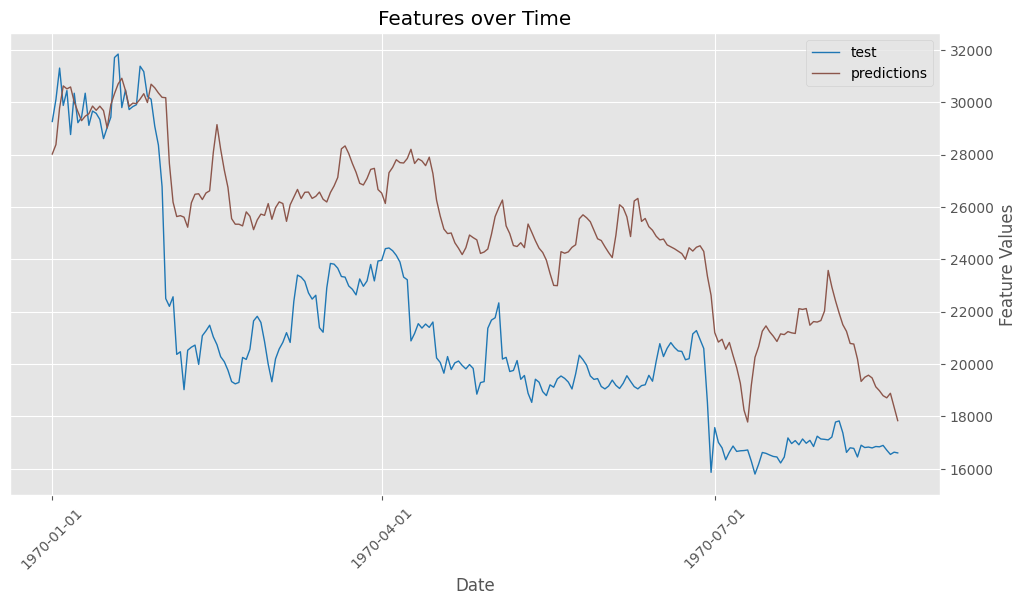

Epoch 1/50
73/73 [==============================] - 11s 48ms/step - loss: 0.1734 - val_loss: 0.0266
Epoch 2/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 3/50
73/73 [==============================] - 1s 18ms/step - loss: 8.4047e-04 - val_loss: 0.0049
Epoch 4/50
73/73 [==============================] - 1s 18ms/step - loss: 6.6847e-04 - val_loss: 0.0046
Epoch 5/50
73/73 [==============================] - 1s 18ms/step - loss: 5.4763e-04 - val_loss: 0.0030
Epoch 6/50
73/73 [==============================] - 1s 18ms/step - loss: 5.5009e-04 - val_loss: 0.0024
Epoch 7/50
73/73 [==============================] - 1s 19ms/step - loss: 4.3166e-04 - val_loss: 0.0030
Epoch 8/50
73/73 [==============================] - 1s 18ms/step - loss: 4.7080e-04 - val_loss: 0.0018
Epoch 9/50
73/73 [==============================] - 2s 21ms/step - loss: 4.8339e-04 - val_loss: 0.0062
Epoch 10/50
73/73 [==============================] - 2s 24ms/step - loss: 4.1628

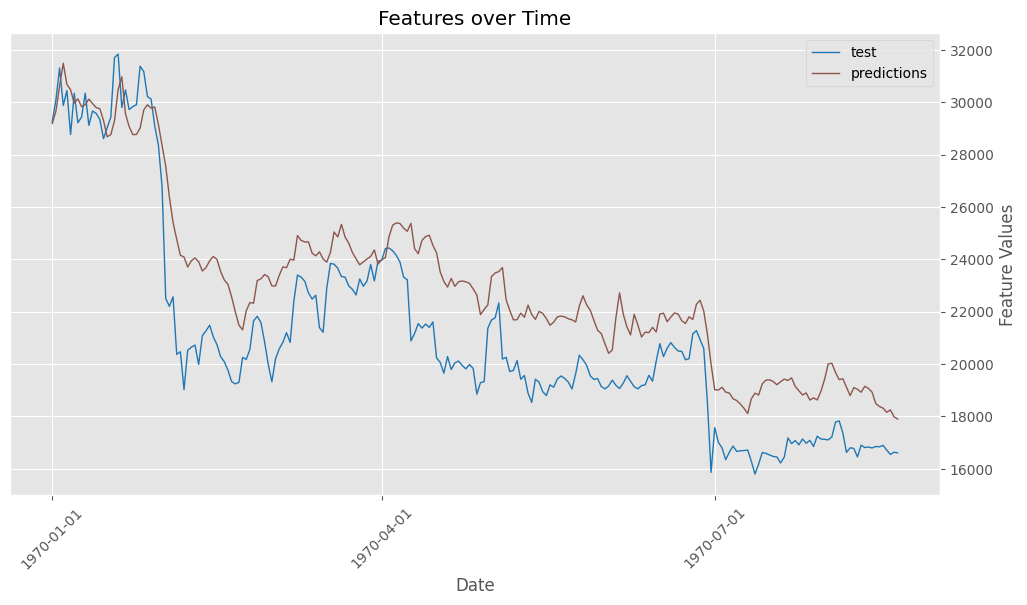

In [84]:
predict_price(ta_df)
predict_price(oc_df)
predict_price(oc_ta_df)

Epoch 1/50
73/73 [==============================] - 14s 32ms/step - loss: 0.1395 - val_loss: 0.0089
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 9.8991e-04 - val_loss: 0.0063
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 6.6476e-04 - val_loss: 0.0025
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 6.1094e-04 - val_loss: 0.0021
Epoch 5/50
73/73 [==============================] - 1s 13ms/step - loss: 6.0809e-04 - val_loss: 0.0044
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 5.0584e-04 - val_loss: 0.0027
Epoch 7/50
73/73 [==============================] - 1s 13ms/step - loss: 4.4338e-04 - val_loss: 0.0017
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 3.5280e-04 - val_loss: 0.0021
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 3.7956e-04 - val_loss: 0.0018
Epoch 10/50
73/73 [==============================] - 1s 13ms/step - loss: 3.

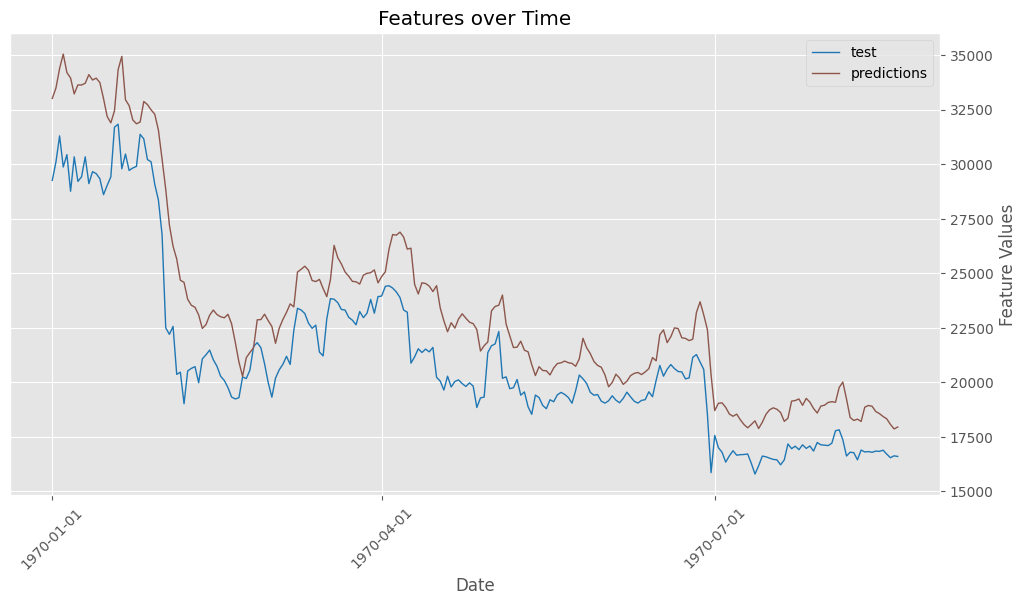

Epoch 1/50
73/73 [==============================] - 8s 31ms/step - loss: 0.1023 - val_loss: 0.0218
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0328
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 6.1901e-04 - val_loss: 0.0588
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 6.2154e-04 - val_loss: 0.0520
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 5.5052e-04 - val_loss: 0.0464
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 4.5172e-04 - val_loss: 0.0501
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 3.9497e-04 - val_loss: 0.0342
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 3.5349e-04 - val_loss: 0.0458
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 3.6014e-04 - val_loss: 0.0399
Epoch 10/50
73/73 [==============================] - 1s 13ms/step - loss: 3.2239e

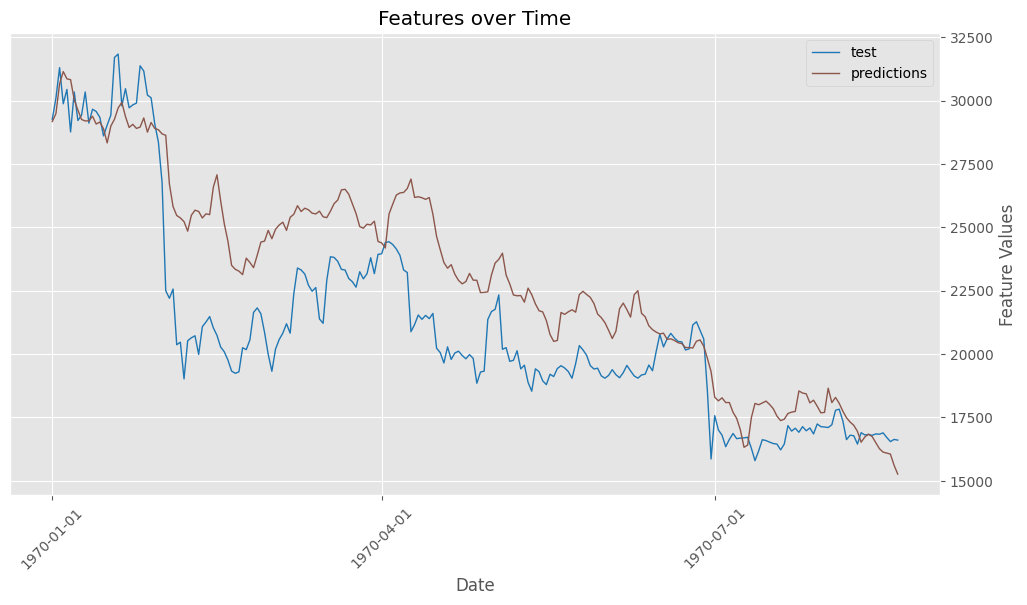

Epoch 1/50
73/73 [==============================] - 8s 32ms/step - loss: 0.2134 - val_loss: 0.0078
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 8.6217e-04 - val_loss: 0.0034
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 7.1071e-04 - val_loss: 0.0030
Epoch 5/50
73/73 [==============================] - 1s 13ms/step - loss: 5.8686e-04 - val_loss: 0.0042
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 5.5103e-04 - val_loss: 0.0034
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 5.1776e-04 - val_loss: 0.0028
Epoch 8/50
73/73 [==============================] - 1s 14ms/step - loss: 5.1666e-04 - val_loss: 0.0051
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 4.2438e-04 - val_loss: 0.0022
Epoch 10/50
73/73 [==============================] - 1s 14ms/step - loss: 4.2157e

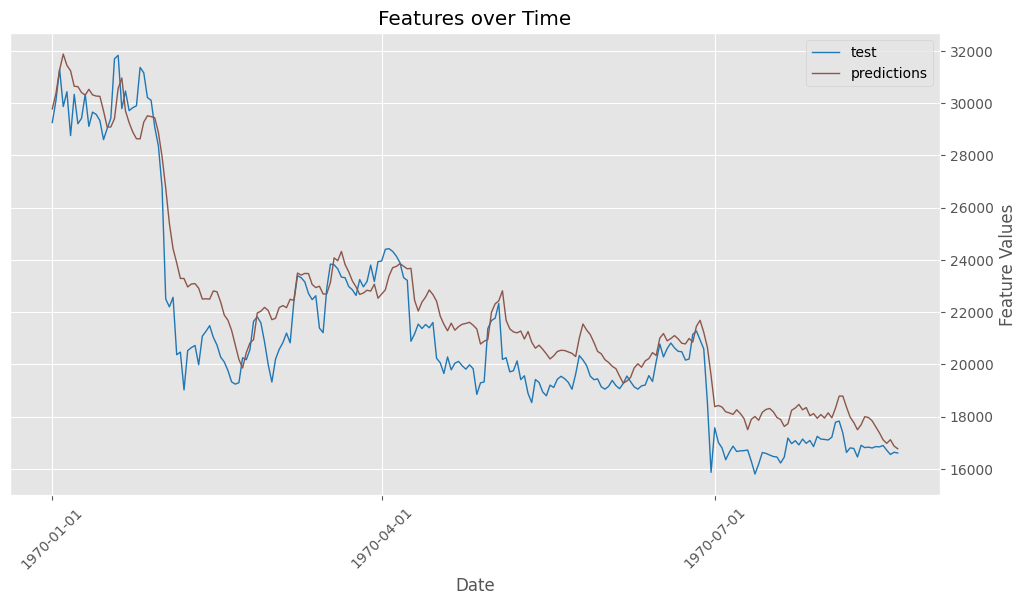

In [14]:
predict_price(ta_df)
predict_price(oc_df)
predict_price(oc_ta_df)

Epoch 1/50
73/73 [==============================] - 9s 31ms/step - loss: 0.1175 - val_loss: 0.0077
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 9.3158e-04 - val_loss: 0.0034
Epoch 3/50
73/73 [==============================] - 1s 13ms/step - loss: 6.7287e-04 - val_loss: 0.0021
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 4.4648e-04 - val_loss: 0.0020
Epoch 5/50
73/73 [==============================] - 1s 13ms/step - loss: 4.9449e-04 - val_loss: 0.0035
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 4.8222e-04 - val_loss: 0.0017
Epoch 7/50
73/73 [==============================] - 1s 13ms/step - loss: 3.8388e-04 - val_loss: 0.0019
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 3.6661e-04 - val_loss: 0.0019
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 3.4888e-04 - val_loss: 0.0017
Epoch 10/50
73/73 [==============================] - 1s 13ms/step - loss: 3.5

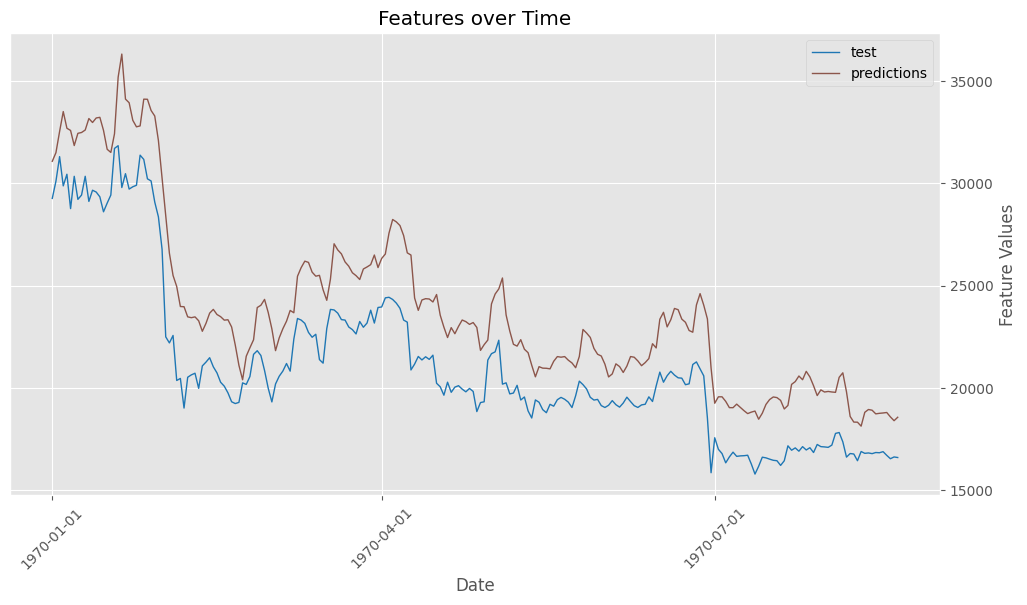

Epoch 1/50
73/73 [==============================] - 9s 31ms/step - loss: 0.1135 - val_loss: 0.0191
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0158
Epoch 3/50
73/73 [==============================] - 1s 13ms/step - loss: 7.5023e-04 - val_loss: 0.0400
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 7.3116e-04 - val_loss: 0.0302
Epoch 5/50
73/73 [==============================] - 1s 13ms/step - loss: 4.9817e-04 - val_loss: 0.0219
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 5.1634e-04 - val_loss: 0.0366
Epoch 7/50
73/73 [==============================] - 1s 13ms/step - loss: 5.1728e-04 - val_loss: 0.0202
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 4.6029e-04 - val_loss: 0.0230
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 4.7422e-04 - val_loss: 0.0238
Epoch 10/50
73/73 [==============================] - 1s 14ms/step - loss: 3.8024e

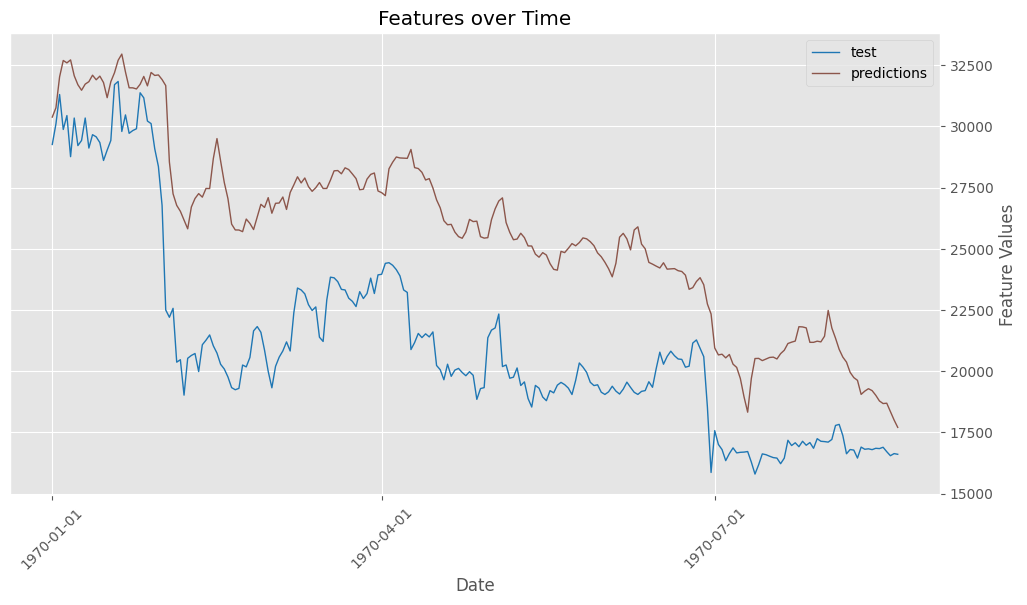

Epoch 1/50
73/73 [==============================] - 9s 32ms/step - loss: 0.1623 - val_loss: 0.0082
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 6.7684e-04 - val_loss: 0.0030
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 5.9291e-04 - val_loss: 0.0042
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 5.0919e-04 - val_loss: 0.0022
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 4.9894e-04 - val_loss: 0.0030
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 4.2682e-04 - val_loss: 0.0031
Epoch 8/50
73/73 [==============================] - 1s 14ms/step - loss: 4.5748e-04 - val_loss: 0.0023
Epoch 9/50
73/73 [==============================] - 1s 14ms/step - loss: 4.0668e-04 - val_loss: 0.0084
Epoch 10/50
73/73 [==============================] - 1s 14ms/step - loss: 3.5625e

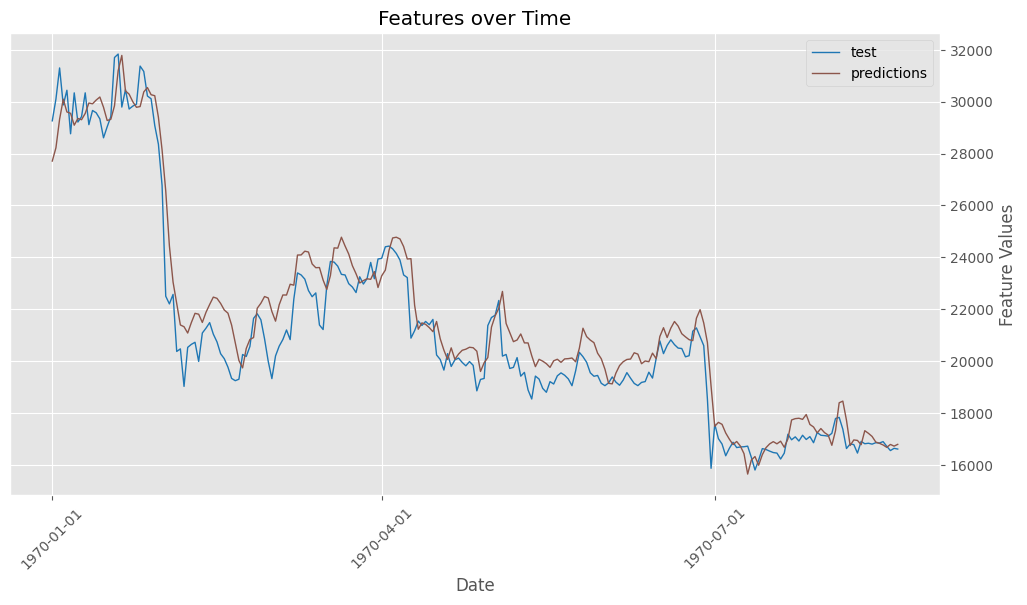

In [16]:
predict_price(ta_df)
predict_price(oc_df)
predict_price(oc_ta_df)

<ipython-input-18-098f019a5d29>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = oc_ta_df.corr()


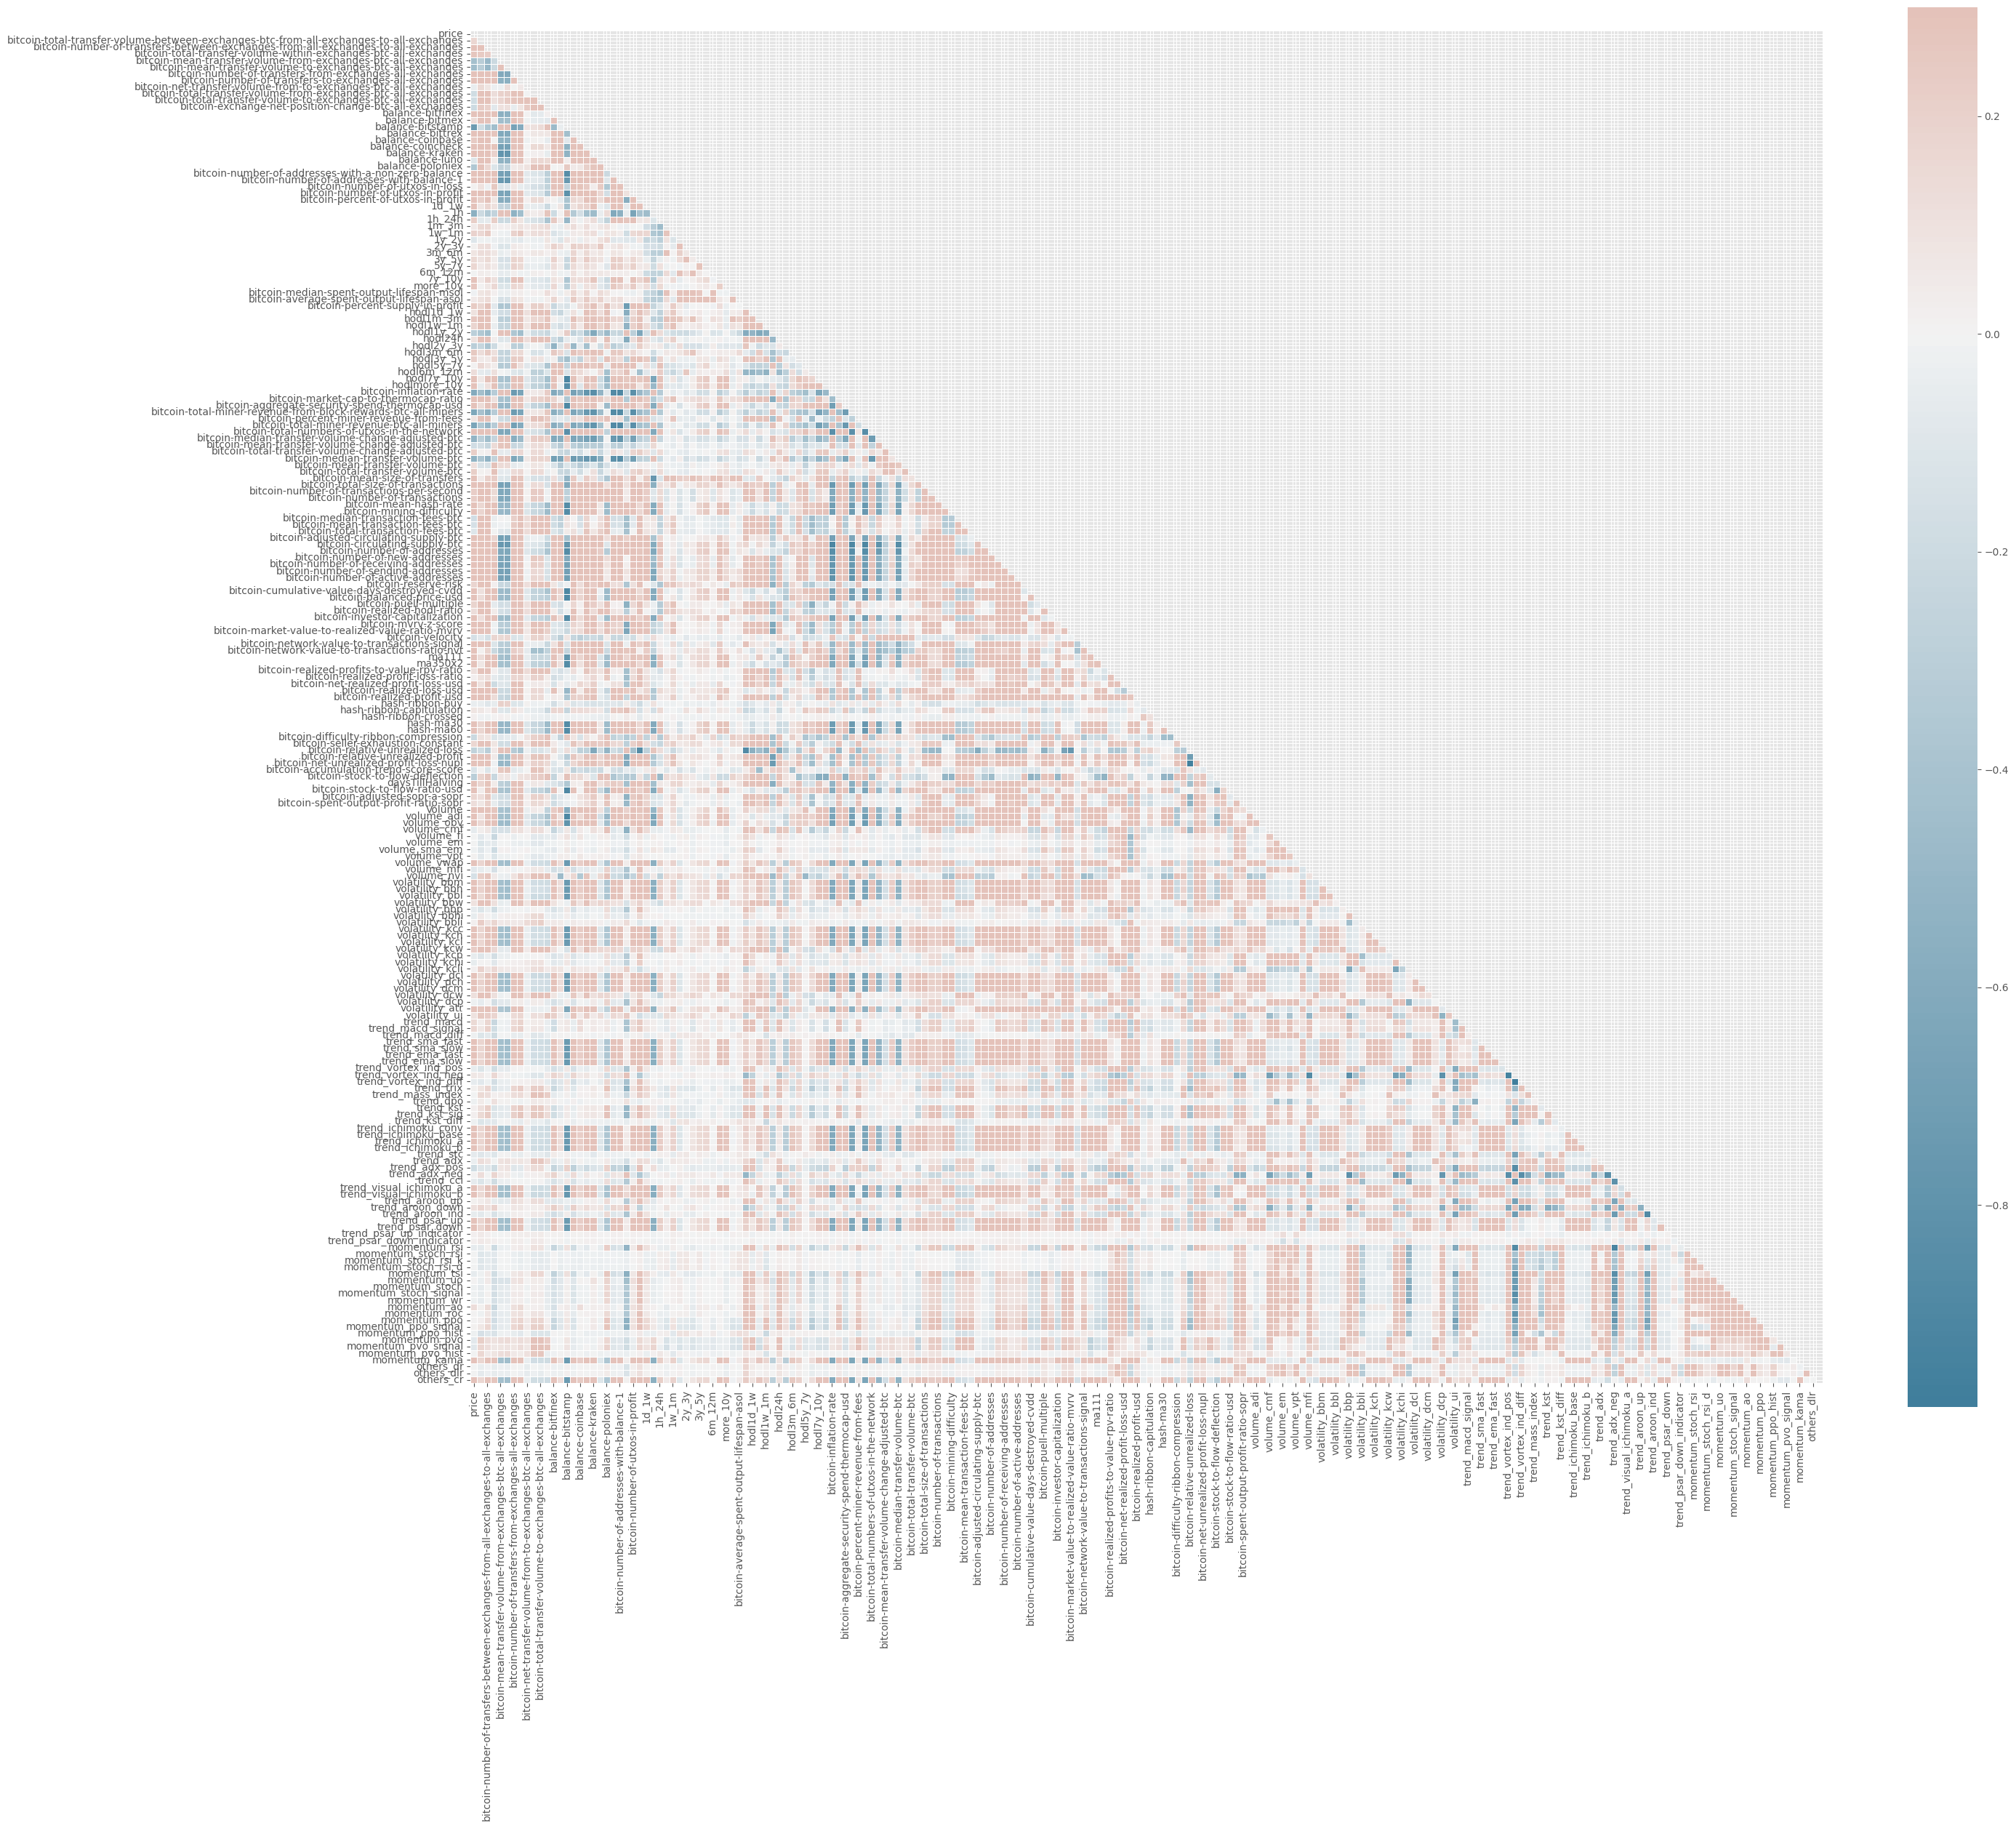

In [18]:
# Compute the correlation matrix
corr = oc_ta_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show the plot
plt.show()

<ipython-input-35-21541c8af5e4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = oc_ta_df.corr()


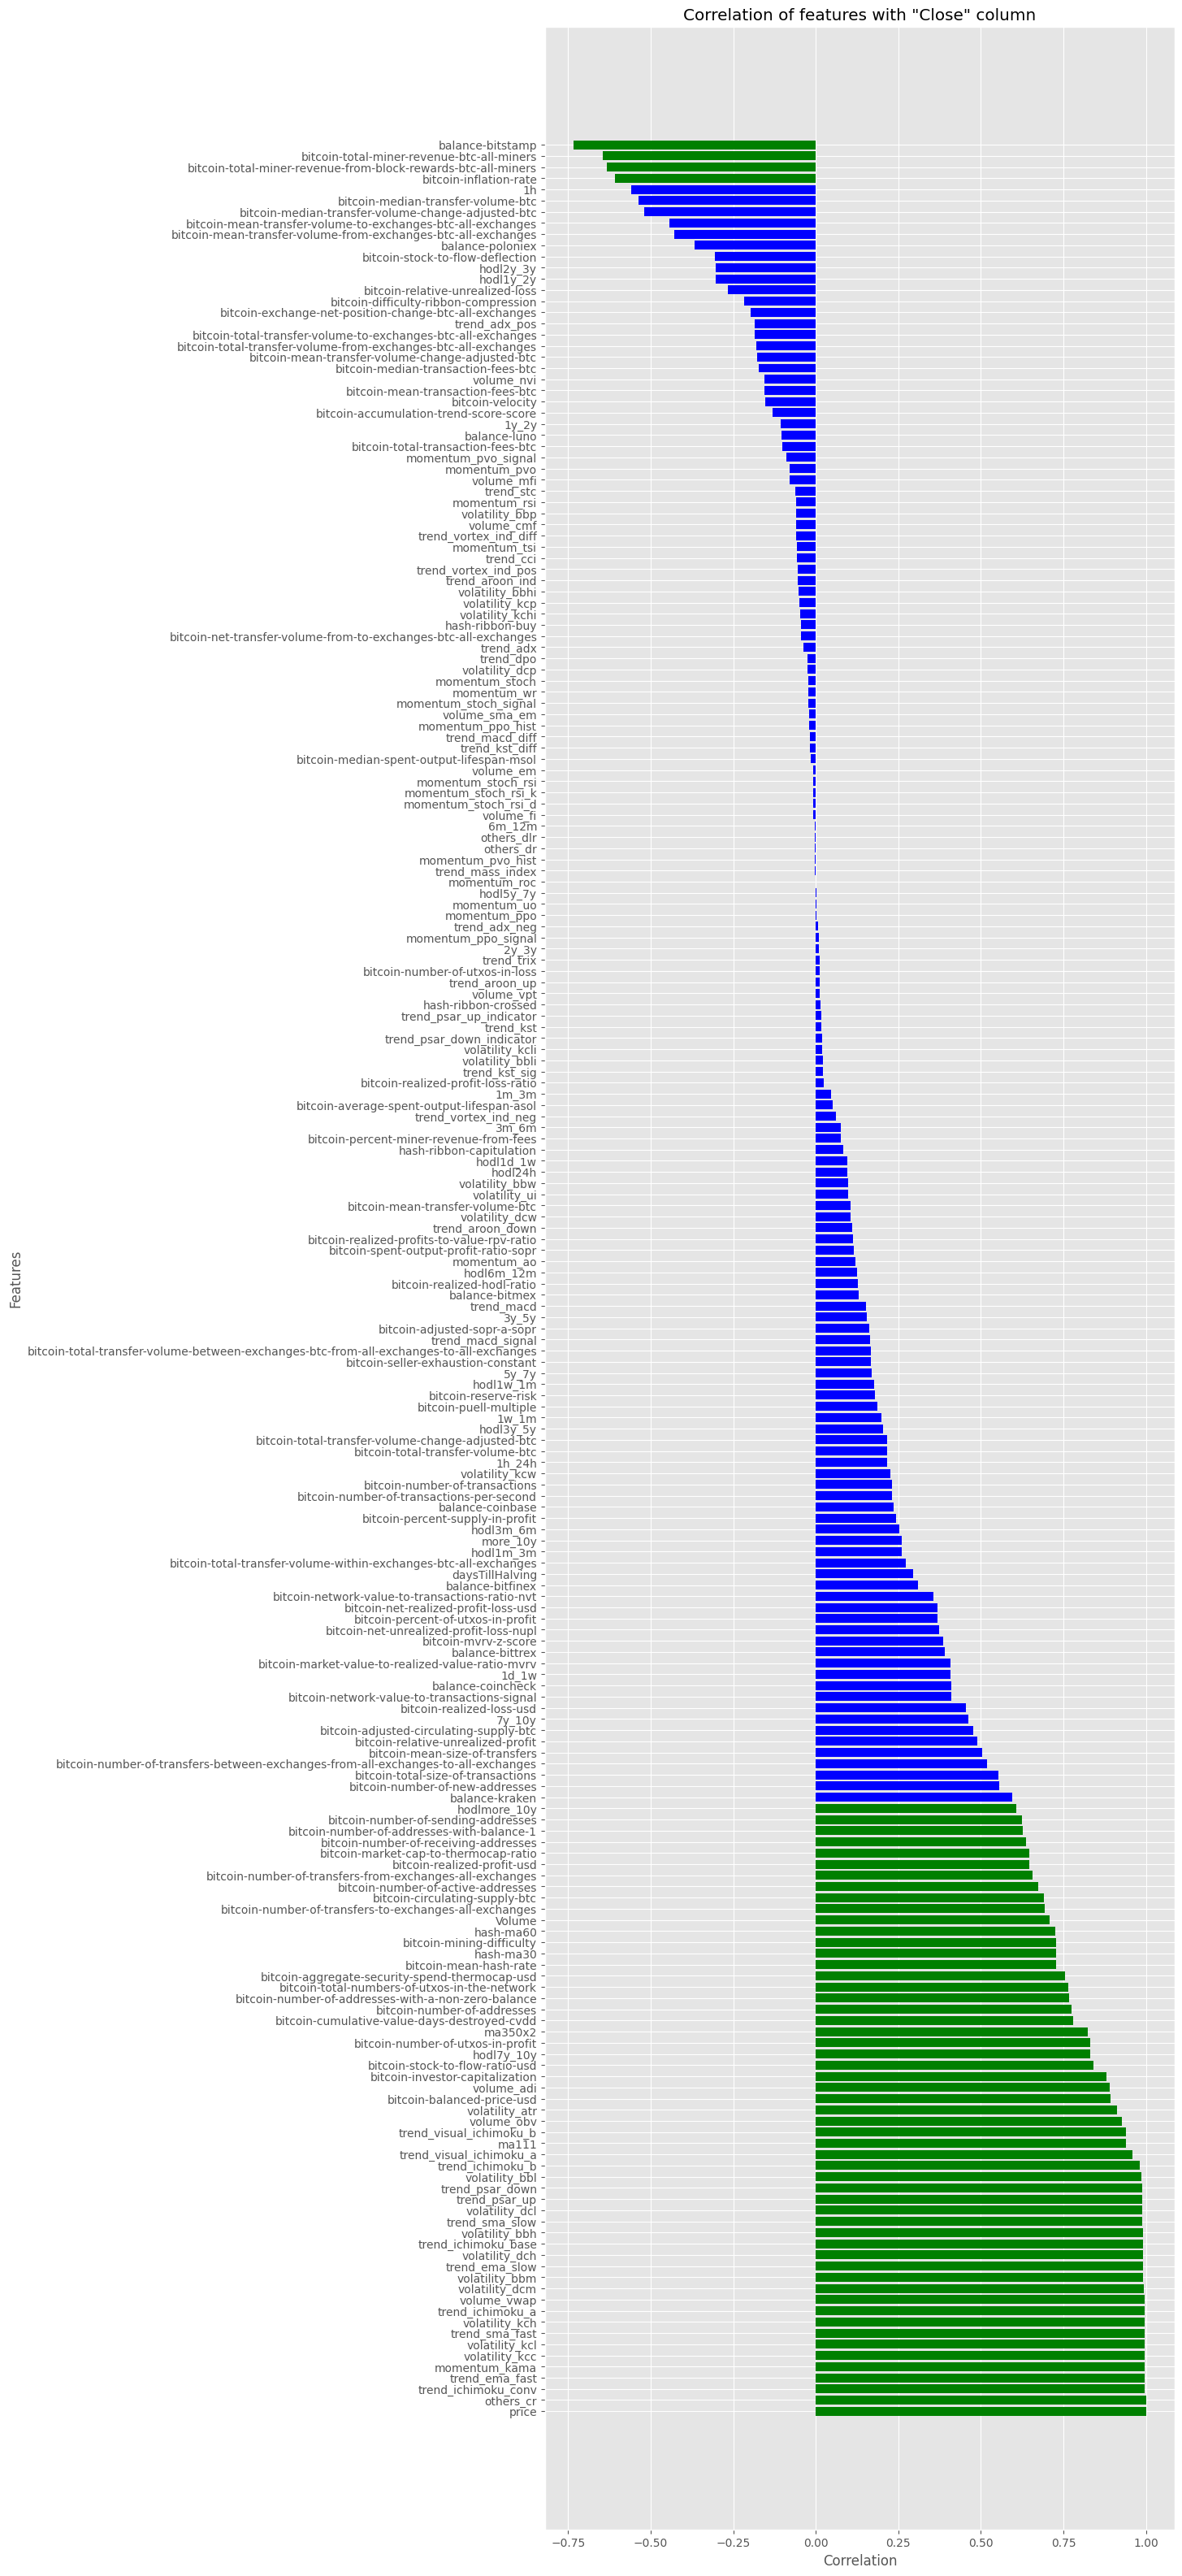

In [35]:
# Compute the correlation matrix
corr_matrix = oc_ta_df.corr()

# Get the correlations of 'Close' with all other variables
close_corr = corr_matrix['price']

# Sort the correlations in descending order
sorted_corr = close_corr.sort_values(ascending=False)

colors = np.where(sorted_corr.abs() > 0.6, 'g', 'b')

# Plot the sorted correlations as a horizontal bar chart
plt.figure(figsize=(10,40))
plt.barh(sorted_corr.index, sorted_corr, color=colors)
plt.title('Correlation of features with "Close" column')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

In [37]:
# Compute the correlation matrix
corr_matrix = oc_ta_df.corr()

# Get the correlations of 'price' with all other variables
close_corr = corr_matrix['price']

# Create a mask for correlations higher than 0.6
mask = close_corr.abs() > 0.6

# Get the names of the features for which the correlation is higher than 0.6
high_corr_features = close_corr[mask].index.tolist()  # convert to list

# Add 'timestamp' to the list of high correlation features
if 'timestamp' not in high_corr_features:  # only add 'timestamp' if it is not already in the list
    high_corr_features.append('timestamp')

# Create a new dataframe with the highly correlated features
high_corr_oc_ta_df = oc_ta_df[high_corr_features]


<ipython-input-37-d95bc8f3c863>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = oc_ta_df.corr()


Epoch 1/50
73/73 [==============================] - 9s 31ms/step - loss: 0.1660 - val_loss: 0.0123
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 3/50
73/73 [==============================] - 1s 13ms/step - loss: 6.6144e-04 - val_loss: 0.0037
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 6.2397e-04 - val_loss: 0.0053
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 5.2817e-04 - val_loss: 0.0021
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 3.8207e-04 - val_loss: 0.0019
Epoch 7/50
73/73 [==============================] - 1s 13ms/step - loss: 3.8474e-04 - val_loss: 0.0019
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 3.6163e-04 - val_loss: 0.0022
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 3.0156e-04 - val_loss: 0.0025
Epoch 10/50
73/73 [==============================] - 1s 13ms/step - loss: 3.6126e

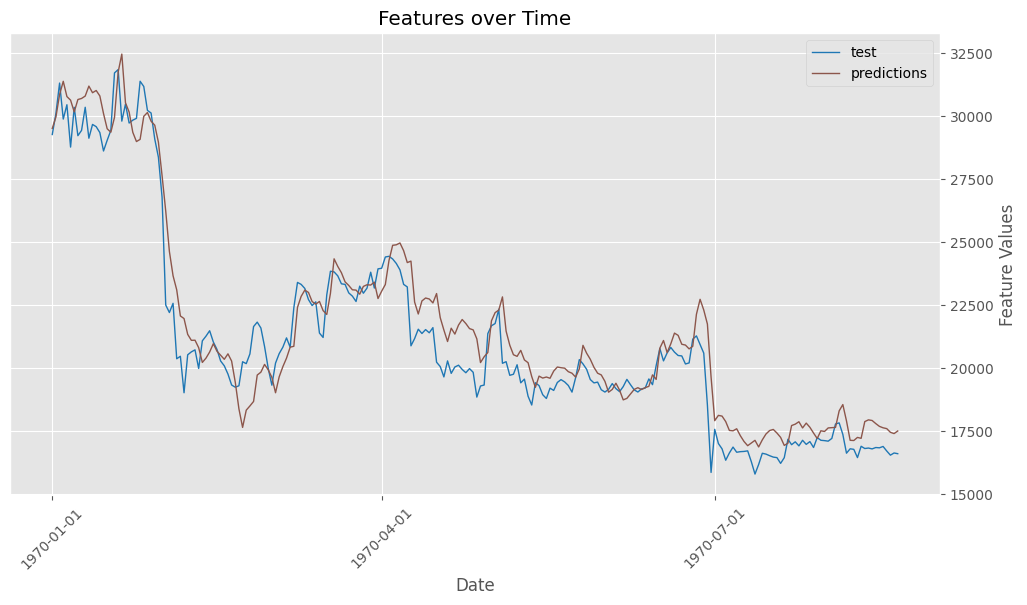

Epoch 1/50
73/73 [==============================] - 8s 31ms/step - loss: 0.1486 - val_loss: 0.0191
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0248
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 7.0239e-04 - val_loss: 0.0383
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 6.9719e-04 - val_loss: 0.0384
Epoch 5/50
73/73 [==============================] - 1s 13ms/step - loss: 5.2816e-04 - val_loss: 0.0311
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 4.4529e-04 - val_loss: 0.0413
Epoch 7/50
73/73 [==============================] - 1s 13ms/step - loss: 4.4003e-04 - val_loss: 0.0228
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 4.5142e-04 - val_loss: 0.0369
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 3.6842e-04 - val_loss: 0.0392
Epoch 10/50
73/73 [==============================] - 1s 13ms/step - loss: 3.7071e

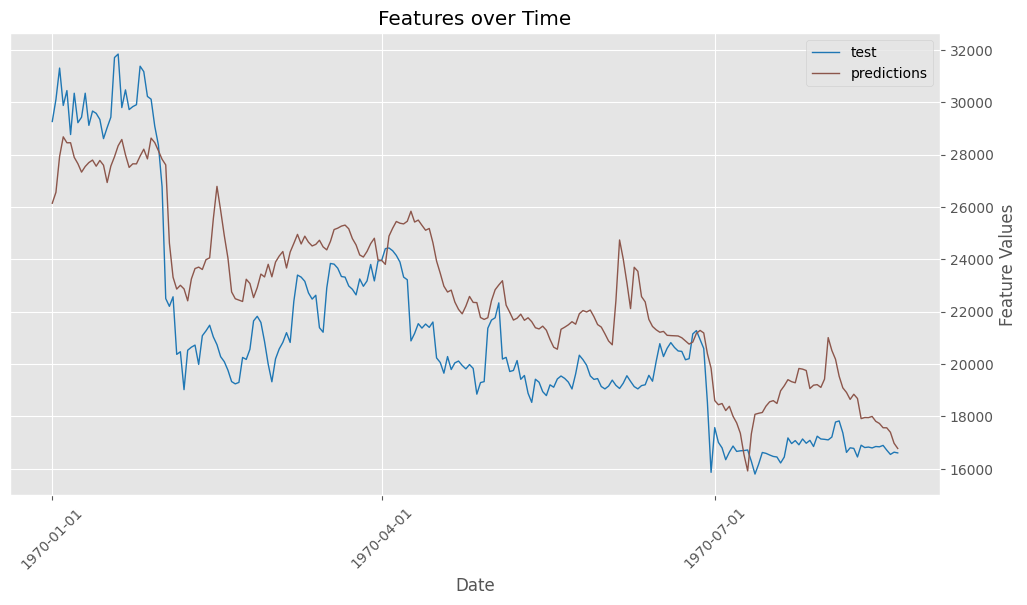

Epoch 1/50
73/73 [==============================] - 8s 31ms/step - loss: 0.2035 - val_loss: 0.0097
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0086
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 8.1394e-04 - val_loss: 0.0054
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 6.4446e-04 - val_loss: 0.0041
Epoch 5/50
73/73 [==============================] - 1s 13ms/step - loss: 5.2248e-04 - val_loss: 0.0118
Epoch 6/50
73/73 [==============================] - 1s 14ms/step - loss: 4.7097e-04 - val_loss: 0.0112
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 4.8800e-04 - val_loss: 0.0066
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 4.4505e-04 - val_loss: 0.0020
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 3.9174e-04 - val_loss: 0.0086
Epoch 10/50
73/73 [==============================] - 1s 13ms/step - loss: 4.3466e

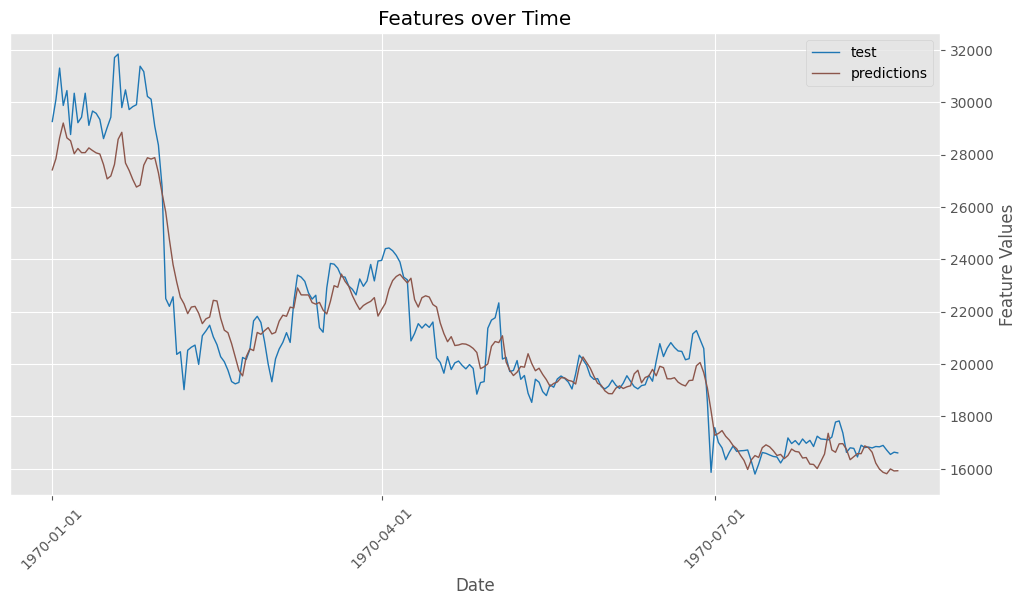

Epoch 1/50
73/73 [==============================] - 9s 31ms/step - loss: 0.0421 - val_loss: 0.0095
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 7.5358e-04 - val_loss: 0.0037
Epoch 3/50
73/73 [==============================] - 1s 13ms/step - loss: 6.1313e-04 - val_loss: 0.0033
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 6.8491e-04 - val_loss: 0.0102
Epoch 5/50
73/73 [==============================] - 1s 13ms/step - loss: 5.0146e-04 - val_loss: 0.0038
Epoch 6/50
73/73 [==============================] - 1s 13ms/step - loss: 4.3041e-04 - val_loss: 0.0027
Epoch 7/50
73/73 [==============================] - 1s 13ms/step - loss: 4.2463e-04 - val_loss: 0.0050
Epoch 8/50
73/73 [==============================] - 1s 13ms/step - loss: 3.4793e-04 - val_loss: 0.0027
Epoch 9/50
73/73 [==============================] - 1s 13ms/step - loss: 3.7027e-04 - val_loss: 0.0036
Epoch 10/50
73/73 [==============================] - 1s 14ms/step - loss: 3.8

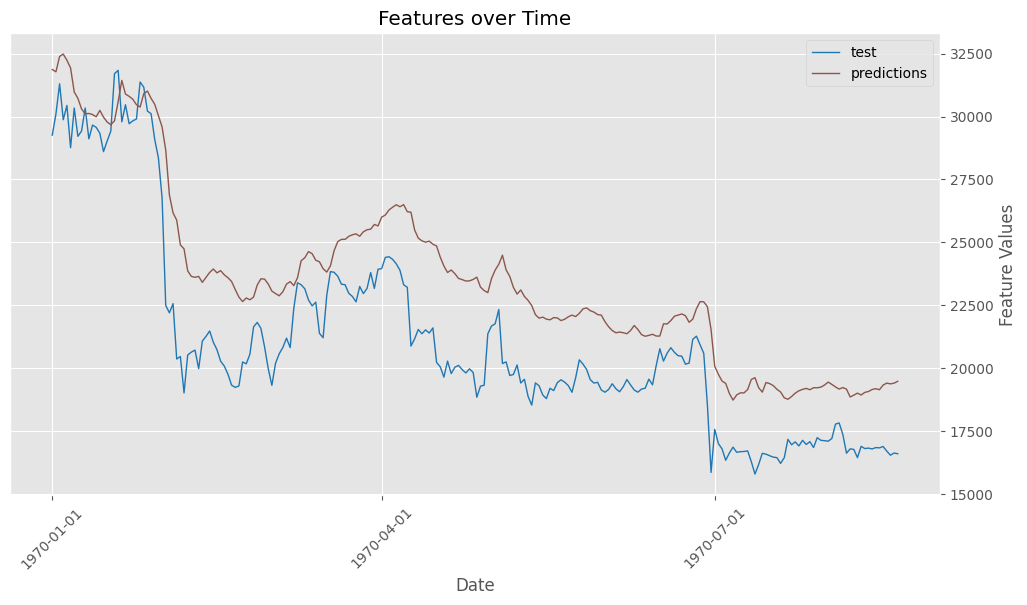

In [52]:
predict_price(ta_df)
predict_price(oc_df)
predict_price(oc_ta_df)
predict_price(high_corr_oc_ta_df)